In [2]:
%matplotlib inline
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator
from HDF5DatasetWriter import HDF5DatasetWriter
from HDF5DatasetGenerator import HDF5DatasetGenerator
from utils import *
from tqdm import tqdm
import cv2
from skimage import io
from Unet import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [41]:
i = 1
data_path = './3Dircadb/3Dircadb1.%d/PATIENT_DICOM'%i
image_slices = [pydicom.dcmread(data_path + '/' + s) for s in os.listdir(data_path)]
image_slices.sort(key = lambda x: int(x.InstanceNumber))

In [42]:
len(image_slices)

129

In [43]:
image_slices[0].pixel_array.shape

(512, 512)

In [44]:
#所以输入的image_slices，形状为（129,512,512）

In [45]:
#image = np.stack([s.pixel_array for s in image_slices])

In [46]:
np.array(image_slices).shape
#此时里面的元素未被解析

(129, 39)

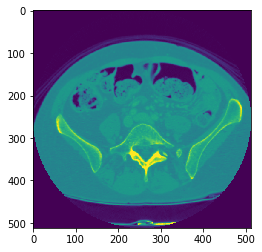

In [47]:
plt.imshow(image_slices[0].pixel_array)

In [48]:
#type(scans[0].pixel_array)
#Out[15]: numpy.ndarray
#scans[0].pixel_array.shape
#Out[16]: (512, 512)
# image.shape: (129,512,512)
image = np.stack([s.pixel_array for s in image_slices])
# Convert to int16 (from sometimes int16), 
# should be possible as values should always be low enough (<32k)
image = image.astype(np.int16)

# Set outside-of-scan pixels to 1
# The intercept is usually -1024, so air is approximately 0
image[image == -2000] = 0
    
# Convert to Hounsfield units (HU)
intercept = image_slices[0].RescaleIntercept
slope = image_slices[0].RescaleSlope
    
if slope != 1:
    image = slope * image.astype(np.float64)
    image = image.astype(np.int16)
        
image += np.int16(intercept)

In [49]:
del image_slices

In [50]:
image.shape

(129, 512, 512)

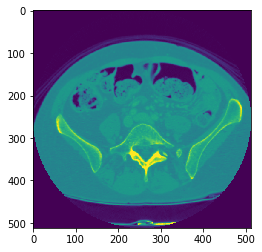

In [51]:
plt.imshow(image[0])

# windowing
<hr>
然而，hu的范围一般来说很大，这就导致了对比度很差，如果需要针对具体的器官进行处理，效果会不好，于是就有了windowing的方法：

In [52]:
def transform_ctdata(image, windowWidth, windowCenter, normal=False):
        """
        注意，这个函数的self.image一定得是float类型的，否则就无效！
        return: trucated image according to window center and window width
        """
        minWindow = float(windowCenter) - 0.5*float(windowWidth)
        newimg = (image - minWindow) / float(windowWidth)
        newimg[newimg < 0] = 0
        newimg[newimg > 1] = 1
        if not normal:
            newimg = (newimg * 255).astype('uint8')
        return newimg
    
images = transform_ctdata(image,500,150)

In [53]:
del image

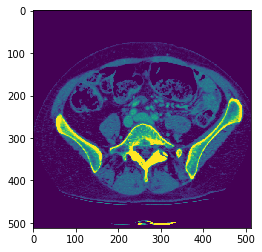

In [54]:
plt.imshow(images[0])

# getRangImageDepth
在训练网络时，一般目标区域越有针对性效果越好，因此经常会在训练前对数据进行预处理，提取出包含有目标的那些切片。

In [118]:
i = 1
label_path = './3Dircadb/3Dircadb1.%d/MASKS_DICOM/liver'%i
"""
args:
image ndarray of shape (depth, height, weight)
"""
liver_slices = [pydicom.dcmread(label_path + '/' + s) for s in os.listdir(label_path)]


print('liver_slices bofore sort')
print(liver_slices[2].InstanceNumber)
liver_slices.sort(key = lambda x: int(x.InstanceNumber))
print('liver_slices after sort')
print(liver_slices[2].InstanceNumber)

liver_slices bofore sort
10
liver_slices after sort
2


In [119]:
livers = np.stack([s.pixel_array for s in liver_slices])
#print(livers)
print(np.where(livers))
print('================'*2)
print(livers.shape)

(array([ 27,  27,  27, ..., 124, 124, 124], dtype=int64), array([209, 209, 209, ..., 222, 223, 223], dtype=int64), array([113, 114, 115, ..., 212, 209, 210], dtype=int64))
(129, 512, 512)


In [120]:
# 得到轴向上出现过目标（label>=1)的切片
z = np.any(livers, axis=(1,2)) # z.shape:(depth,)  any返回是否有值
startposition,endposition = np.where(z)[0][[0,-1]]


print(startposition,endposition)

27 124


In [121]:
print(z.shape)

(129,)


In [122]:
np.where(z)

(array([ 27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124], dtype=int64),)

In [123]:
del z,liver_slices

# 直方图均衡化

函数clahe_equalized

它是一种局部局部来的均衡化，也就是是说把整个图像分成许多小块（比如按10*10作为一个小块），那么对每个小块进行均衡化。这种方法主要对于图像直方图不是那么单一的（比如存在多峰情况）图像比较实用。Opencv中将这种方法称之为CLAHE，使用到的函数就是cv2.createCLAHE()，一个实例如下：


In [103]:
assert (len(images.shape)==3)  #3D arrays
#create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
imgs_equalized = np.empty(images.shape)
for i in range(startposition, endposition+1):
    imgs_equalized[i,:,:] = clahe.apply(np.array(images[i,:,:], dtype = np.uint8))


In [104]:
np.where(images[50])

(array([ 59,  59,  59, ..., 505, 505, 505], dtype=int64),
 array([241, 242, 243, ..., 271, 272, 273], dtype=int64))

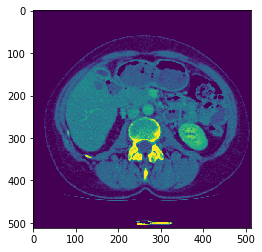

In [105]:
plt.imshow(images[50])

In [106]:
imgs_equalized[50][195][160]

143.0

In [115]:
print(livers[0][0][0])
livers[50][195][160]

0


255

In [124]:
del livers

In [107]:
np.where(imgs_equalized[50])

(array([  0,   0,   0, ..., 511, 511, 511], dtype=int64),
 array([  0,   1,   2, ..., 509, 510, 511], dtype=int64))

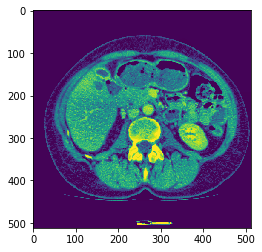

In [108]:
plt.imshow(imgs_equalized[50])

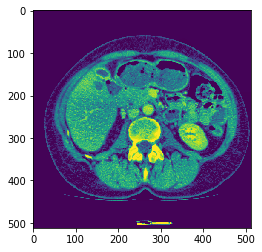

In [109]:
imgs_equalized /= 255
plt.imshow(imgs_equalized[50])

In [110]:
imgs_equalized[50][195][160]

0.5607843137254902

In [29]:
print('imgs_equalized',imgs_equalized.shape)
full_images = []
full_images.append(imgs_equalized)

full_images = np.vstack(full_images)
full_images = np.expand_dims(full_images,axis=-1)
print('full_images',full_images.shape)

imgs_equalized (129, 512, 512)
full_images (129, 512, 512, 1)


In [30]:
seed=1
image_datagen = ImageDataGenerator()
image_datagen.fit(full_images, augment=True, seed=seed)
image_generator = image_datagen.flow(full_images,seed=seed)

In [33]:
x = []
i = 0

x.append(image_generator.next())
x.append(image_generator.next())
x.append(image_generator.next())

x = np.vstack(x)
print(x.shape)

(65, 512, 512, 1)
